# Importing the libraries.

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
print(torch.__version__)

1.4.0


#  Next Important step is Data Transformation.

#### We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.

### Here is the list of all the transformations which come pre-built with PyTorch

#### Compose
#### ToTensor
#### ToPILImage
#### Normalize
#### Resize
#### Scale
#### CenterCrop
#### Pad
#### Lambda
#### RandomApply
#### RandomChoice
#### RandomOrder
#### RandomCrop
#### RandomHorizontalFlip
#### RandomVerticalFlip
#### RandomResizedCrop
#### RandomSizedCrop
#### FiveCrop
#### TenCrop
#### LinearTransformation
#### ColorJitter
#### RandomRotation
#### RandomAffine
#### Grayscale
#### RandomGrayscale
#### RandomPerspective
#### RandomErasing

## Transforming our data

### Now we will be normalizing our data and also will be converting our data into tensors hence first find out the mean and standard deviation of our data because those are the numbers we will need to supply in the Normalize function.

# We will be applying image augmentation in this time by rotating our images by 5 degrees and that will be done to training data just to make our training data harder and this will be done in transform column only.

In [3]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

C:\Users\RASHU TYAGI\AppData\Roaming\Python\Python37\site-packages\torchvision\datasets\mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


## Mean = 0.1307 and Standard Deviation = 0.3081

In [4]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation(degrees = (-7.0, 7.0),fill = (1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset

In [5]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders

In [6]:
SEED = 1 # so that we get same random sample everytime.

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility --> so that we get same random sample everytime.
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Model.

#### Now we will be increasing the capacity of our model which means we will be increasing the number of channels of our model towards the end (after GAP layer).Also we will be using the Dropout layer after every layer because that's the right way to do it.

### Here in this model we will be performing maxpooling after getting a receptive field of 5*5 only because as we can see that 5 pixels are enough to get the view of the image to an extent that it is recognizable.

In [8]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
            
        ) # output_size = 24
        
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2)
         # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 11
        
        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout(dropout_value)
           
        ) # output_size = 9
        #self.pool2 = nn.MaxPool2d(2, 2)
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 7

        

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            #nn.BatchNorm2d(16),
            #nn.ReLU(),
            #nn.Dropout(dropout_value)
       #) # output_size = 7

        #self.convblock8 = nn.Sequential(
            #nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10), NEVER
            # nn.ReLU() NEVER!
        ) # output_size = 1

        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        #x = self.pool1(x)
        #x = self.dropout(x)
        
        x = self.convblock4(x)
       
        x = self.convblock5(x)
        #x = self.pool2(x)
        x = self.convblock6(x)
        
        #x = self.dropout(x)
        x = self.gap(x) 
        x = self.convblock7(x)
        #x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

## It is important to view the model summary and the model parameters and as there is not inbuilt function hence we do it using the following code

In [9]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10           [-1, 16, 10, 10]           2,304
             ReLU-11           [-1, 16, 10, 10]               0
      BatchNorm2d-12           [-1, 16, 10, 10]              32
          Dropout-13           [-1, 16, 10, 10]               0
           Conv2d-14             [

### So we can see that we have  9896 parameters lets try for the accuracy.


# Train and Test Functions.

In [10]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)  #nll means negative log loss
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [11]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.1688564270734787 Batch_id=468 Accuracy=83.09: 100%|███████████████████████████| 469/469 [00:07<00:00, 59.96it/s]



Test set: Average loss: 0.0986, Accuracy: 9748/10000 (97.48%)

EPOCH: 1


Loss=0.06040928140282631 Batch_id=468 Accuracy=96.87: 100%|██████████████████████████| 469/469 [00:07<00:00, 60.81it/s]



Test set: Average loss: 0.0538, Accuracy: 9847/10000 (98.47%)

EPOCH: 2


Loss=0.13571800291538239 Batch_id=468 Accuracy=97.60: 100%|██████████████████████████| 469/469 [00:07<00:00, 60.99it/s]



Test set: Average loss: 0.0422, Accuracy: 9884/10000 (98.84%)

EPOCH: 3


Loss=0.06797555088996887 Batch_id=468 Accuracy=97.94: 100%|██████████████████████████| 469/469 [00:07<00:00, 59.82it/s]



Test set: Average loss: 0.0423, Accuracy: 9873/10000 (98.73%)

EPOCH: 4


Loss=0.12017613649368286 Batch_id=468 Accuracy=98.16: 100%|██████████████████████████| 469/469 [00:08<00:00, 58.09it/s]



Test set: Average loss: 0.0403, Accuracy: 9879/10000 (98.79%)

EPOCH: 5


Loss=0.040220096707344055 Batch_id=468 Accuracy=98.33: 100%|█████████████████████████| 469/469 [00:07<00:00, 59.41it/s]



Test set: Average loss: 0.0299, Accuracy: 9913/10000 (99.13%)

EPOCH: 6


Loss=0.014273206703364849 Batch_id=468 Accuracy=98.39: 100%|█████████████████████████| 469/469 [00:08<00:00, 58.38it/s]



Test set: Average loss: 0.0378, Accuracy: 9879/10000 (98.79%)

EPOCH: 7


Loss=0.009669129736721516 Batch_id=468 Accuracy=98.46: 100%|█████████████████████████| 469/469 [00:07<00:00, 59.38it/s]



Test set: Average loss: 0.0303, Accuracy: 9910/10000 (99.10%)

EPOCH: 8


Loss=0.036205094307661057 Batch_id=468 Accuracy=98.53: 100%|█████████████████████████| 469/469 [00:07<00:00, 59.77it/s]



Test set: Average loss: 0.0275, Accuracy: 9915/10000 (99.15%)

EPOCH: 9


Loss=0.014077037572860718 Batch_id=468 Accuracy=98.61: 100%|█████████████████████████| 469/469 [00:07<00:00, 60.60it/s]



Test set: Average loss: 0.0284, Accuracy: 9911/10000 (99.11%)

EPOCH: 10


Loss=0.048232704401016235 Batch_id=468 Accuracy=98.61: 100%|█████████████████████████| 469/469 [00:08<00:00, 57.94it/s]



Test set: Average loss: 0.0309, Accuracy: 9912/10000 (99.12%)

EPOCH: 11


Loss=0.023835331201553345 Batch_id=468 Accuracy=98.66: 100%|█████████████████████████| 469/469 [00:07<00:00, 75.71it/s]



Test set: Average loss: 0.0264, Accuracy: 9921/10000 (99.21%)

EPOCH: 12


Loss=0.03938356041908264 Batch_id=468 Accuracy=98.77: 100%|██████████████████████████| 469/469 [00:08<00:00, 53.51it/s]



Test set: Average loss: 0.0249, Accuracy: 9915/10000 (99.15%)

EPOCH: 13


Loss=0.031098827719688416 Batch_id=468 Accuracy=98.66: 100%|█████████████████████████| 469/469 [00:12<00:00, 36.33it/s]



Test set: Average loss: 0.0253, Accuracy: 9919/10000 (99.19%)

EPOCH: 14


Loss=0.04942558333277702 Batch_id=468 Accuracy=98.76: 100%|██████████████████████████| 469/469 [00:08<00:00, 71.72it/s]



Test set: Average loss: 0.0261, Accuracy: 9921/10000 (99.21%)

EPOCH: 15


Loss=0.01594415307044983 Batch_id=468 Accuracy=98.80: 100%|██████████████████████████| 469/469 [00:08<00:00, 55.15it/s]



Test set: Average loss: 0.0225, Accuracy: 9928/10000 (99.28%)

EPOCH: 16


Loss=0.04095020517706871 Batch_id=468 Accuracy=98.75: 100%|██████████████████████████| 469/469 [00:08<00:00, 73.51it/s]



Test set: Average loss: 0.0242, Accuracy: 9925/10000 (99.25%)

EPOCH: 17


Loss=0.0453893207013607 Batch_id=468 Accuracy=98.81: 100%|███████████████████████████| 469/469 [00:08<00:00, 55.03it/s]



Test set: Average loss: 0.0196, Accuracy: 9941/10000 (99.41%)

EPOCH: 18


Loss=0.010398929007351398 Batch_id=468 Accuracy=98.80: 100%|█████████████████████████| 469/469 [00:08<00:00, 54.53it/s]



Test set: Average loss: 0.0225, Accuracy: 9935/10000 (99.35%)

EPOCH: 19


Loss=0.04404287412762642 Batch_id=468 Accuracy=98.88: 100%|██████████████████████████| 469/469 [00:08<00:00, 55.88it/s]



Test set: Average loss: 0.0230, Accuracy: 9921/10000 (99.21%)



# Results :-

### 1.) Best Training Accuracy: 98.88%
### 2.) Best Test Accuracy : 99.41%
### 3.) Number of parameters : 9896

### Regularization Worked perfectly here as we have no overfitting at all.

### But we can see a little bit of underfitting because we know that we have made our training data harder hence training accuracy is expected to get low.And we might not have such harder images in test data hence test accuracy is good.

### Switch to Round 10 where we try to make furthur improvements.

Text(0.5, 1.0, 'Test Accuracy')

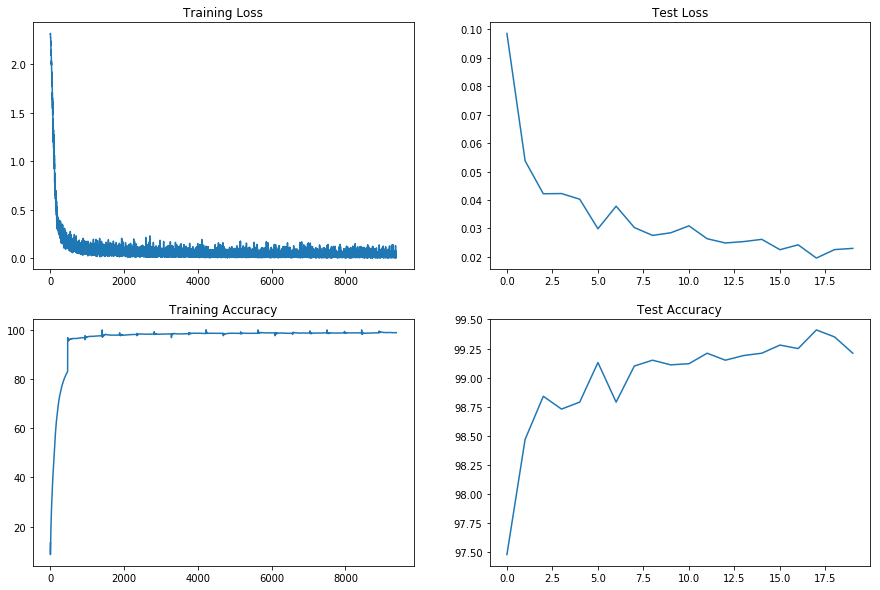

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")